In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
%matplotlib inline

In [3]:
regionNamesRaw  ="""
ctx-lh-bankssts
ctx-lh-caudalanteriorcingulate
ctx-lh-caudalmiddlefrontal
ctx-lh-cuneus
ctx-lh-entorhinal
ctx-lh-frontalpole
ctx-lh-fusiform
ctx-lh-inferiorparietal
ctx-lh-inferiortemporal
ctx-lh-insula
ctx-lh-isthmuscingulate
ctx-lh-lateraloccipital
ctx-lh-lateralorbitofrontal
ctx-lh-lingual
ctx-lh-medialorbitofrontal
ctx-lh-middletemporal
ctx-lh-paracentral
ctx-lh-parahippocampal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-pericalcarine
ctx-lh-postcentral
ctx-lh-posteriorcingulate
ctx-lh-precentral
ctx-lh-precuneus
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-superiorparietal
ctx-lh-superiortemporal
ctx-lh-supramarginal
ctx-lh-temporalpole
ctx-lh-transversetemporal
ctx-rh-bankssts
ctx-rh-caudalanteriorcingulate
ctx-rh-caudalmiddlefrontal
ctx-rh-cuneus
ctx-rh-entorhinal
ctx-rh-frontalpole
ctx-rh-fusiform
ctx-rh-inferiorparietal
ctx-rh-inferiortemporal
ctx-rh-insula
ctx-rh-isthmuscingulate
ctx-rh-lateraloccipital
ctx-rh-lateralorbitofrontal
ctx-rh-lingual
ctx-rh-medialorbitofrontal
ctx-rh-middletemporal
ctx-rh-paracentral
ctx-rh-parahippocampal
ctx-rh-parsopercularis
ctx-rh-parsorbitalis
ctx-rh-parstriangularis
ctx-rh-pericalcarine
ctx-rh-postcentral
ctx-rh-posteriorcingulate
ctx-rh-precentral
ctx-rh-precuneus
ctx-rh-rostralanteriorcingulate
ctx-rh-rostralmiddlefrontal
ctx-rh-superiorfrontal
ctx-rh-superiorparietal
ctx-rh-superiortemporal
ctx-rh-supramarginal
ctx-rh-temporalpole
ctx-rh-transversetemporal
"""
regionNames = [i.strip()[4].title() + i.strip()[6:].title() for i in regionNamesRaw.split("\n") if len(i.strip())>0]

In [4]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

### The keep index

In [787]:

RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
ADlabs = [lab[0].split("A")[0] for lab in RID_AD_labs] 
RID_Ctrl_labs = loadmat("./OtherFils/radid_control.mat")["radid"].reshape(-1)
Ctrllabs = [lab[0].split("A")[0] for lab in RID_Ctrl_labs] 

kpAD = []
for ADlab in ADlabs:
    kpAD.append(np.sum(ADSum["RID"] == ADlab))
kpAD = np.array(kpAD)
kpCtrl = []
for Ctrllab in Ctrllabs:
    kpCtrl.append(np.sum(CtrlSum["RID"] == Ctrllab))
kpCtrl = np.array(kpCtrl)

kpAll = np.concatenate([kpAD, kpCtrl])

In [743]:
with open("./OtherFils/KpIdxs.pkl", "wb") as sf:
    pickle.dump([kpAD, kpCtrl, kpAll], sf)

## Load features

### Load data

In [5]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [6]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [7]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [8]:
fil = list(resDir.glob("AD_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [9]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1]

In [10]:
def minmax2(x):
    num = 2 * (x-np.min(x))
    den = np.max(x) - np.min(x)
    return num/den - 1

In [11]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

fcR = pd.read_csv('./OtherFils/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    # lh = minmax(fcRar[:34])
    # rh = minmax(fcRar[34:])
    # fcRarrMM[i, :34] = lh
    # fcRarrMM[i, 34:] = rh
    fcRarrMM[i, :] = minmax(fcRar)

In [11]:
def halfMinmax(x):
    lpMM = minmax(x[:34])
    rpMM = minmax(x[34:])
    res = np.concatenate([lpMM, rpMM])
    return res

### The basic data transformation 

In [107]:
def rmRepFn(eigVal):
    firstCol = np.array([[True] * np.array(eigVal).shape[0]]).T
    otherCols = np.diff(np.abs(eigVal), 1)!=0
    tmpKpIdx = np.concatenate([firstCol, otherCols], axis=1)
    rmEigVals = np.array(eigVal)[:, tmpKpIdx[0, :]]
    return rmEigVals

In [114]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [115]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [116]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

##  Distinguish between AD anc Ctrl

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
import statsmodels.api as sm

from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats import fisher_exact, norm
from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict


from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [37]:
def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4], penalty="l2"):
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(inpX):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(inpX[trIdxs, :], inpY[trIdxs])
            eProbs.append(clf.predict_proba(inpX[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(inpY, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(inpY, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
            
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res

### Logistic under different features

In [284]:
penalty= "l2"
fsNameSet = [
    #["r"], ["maxwU"], ["ncpts"],  ["wUsumAll"],  ["wUmeanAll"], 
             #["r", "ncpts"],
             #["ncpts", "maxwU"],  ["ncpts", "wUsumAll"],  ["ncpts", "wUmeanAll"], 
             #["r", "maxwU"],  ["r", "wUsumAll"],  
             #["r", "wUmeanAll"], 
             #["r", "ncpts", "maxwU"], 
             #["r", "ncpts", "wUsumAll"],  
             ["r", "ncpts", "absEigValMean", "wUmeanAll"], 
             #["r", "ncpts", "maxDwell", "wUmeanAll"], 
           ]
#fsNameSet = [ 
#              ["r", "ncpts", "wUmeanAll"], 
#            ]
Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
print("="*100)
print(f"The penalty is {penalty}.")
for fsName in tqdm(fsNameSet):
    Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
    XsAD = []
    XsCtrl = []
    for fName in fsName:
        if isinstance(fsAD[0][fName], numbers.Number):
            cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
            cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
        else:
            cfAD = np.array([fs[fName] for fs in fsAD])
            cfCtrl = np.array([fs[fName] for fs in fsCtrl])
        
        XsAD.append(cfAD)
        XsCtrl.append(cfCtrl)
    XsAD = np.concatenate(XsAD, axis=1)
    XsCtrl = np.concatenate(XsCtrl, axis=1)
    Xs = np.concatenate([XsAD, XsCtrl], axis=0)
    stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
    
    
    eProbs = []
    loo = LeaveOneOut()
    parass = []
    optC = TuningCFn(stdXs, Ys, Cs=Cs, penalty=penalty)["optC"]
    #print(optC)
    for trIdxs, testIdxs in loo.split(stdXs):
        curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs=Cs, penalty=penalty)["optC"]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        #clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(curStdXs, curYs)
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    parass = np.array(parass)
    
    optC = TuningCFn(stdXs, Ys, Cs=Cs, penalty=penalty)["optC"]
    nobs = stdXs.shape[0]
    Aucss = []
    for j in range(1000):
        testIdx = np.random.choice(nobs, int(nobs/5), False)
        trainIdx = np.delete(np.arange(nobs), testIdx)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(stdXs[trainIdx], Ys[trainIdx])
        curEprobs = clf.predict_proba(stdXs[testIdx, :])
        curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
        Aucss.append(curAuc)
    mAUC = np.mean(Aucss)
    stdAUC = np.std(Aucss)
    print(f"Features are {fsName}.")
    print(f"The AUC under optimal C is {auc:.3f}.")
    print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    print("-"*100)

  0%|          | 0/1 [00:00<?, ?it/s]

The penalty is l2.


100%|██████████| 1/1 [00:06<00:00,  6.23s/it]

Features are ['r', 'ncpts', 'maxDwell', 'wUmeanAll'].
The AUC under optimal C is 0.767.
The mean of AUC under 1000 repetitions is 0.763 and the standard deviation is 0.077.
----------------------------------------------------------------------------------------------------


### Choose one model under the Logistic

#### Results when add age cov

In [158]:
bslineDat = pd.read_csv("./OtherFils/AllDataBaseline.csv")

In [159]:
RID_AD_labs = loadmat("./OtherFils/radid_AD.mat")["radid"].reshape(-1)
ADlabs = [lab[0].split("A")[0] for lab in RID_AD_labs] 
RID_Ctrl_labs = loadmat("./OtherFils/radid_control.mat")["radid"].reshape(-1)
Ctrllabs = [lab[0].split("A")[0] for lab in RID_Ctrl_labs] 
RID_Ctrl_labs_Add = loadmat("./OtherFils/radid_control_add.mat")["radid"].reshape(-1)
CtrllabsAdd = [lab[0] for lab in RID_Ctrl_labs_Add] 
CtrllabsBoth = Ctrllabs + CtrllabsAdd

In [171]:
ageAD = []
for ADlab in ADlabs:
    ageAD.append(np.array(bslineDat["MEG_Age"][bslineDat["RID"] == ADlab])[0])
ageAD = np.array(ageAD)

ageCtrl = []
for Ctrllab in CtrllabsBoth:
    ageCtrl.append(np.array(bslineDat["MEG_Age"][bslineDat["RID"] == Ctrllab])[0])
ageCtrl = np.array(ageCtrl)

ageAll = np.concatenate([ageAD, ageCtrl])
stdAge = (ageAll - np.mean(ageAll))/np.std(ageAll)

In [172]:
stdAge = np.array([ix for ix, kpId in zip(stdAge, kpAll) if kpId!=0])

In [177]:
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

stdXs = np.concatenate([stdAge.reshape(-1, 1), stdXs], axis=1)

gOptC = TuningCFn(stdXs, Ys, Cs)["optC"]

clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1)


np.random.seed(0)
repTime = 10000
parassBoot = []
for i in tqdm(range(repTime)):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    parassBoot.append(parasBoot)
    
parassBoot = np.array(parassBoot)
lows, ups = coefsFinal-parassBoot.std(axis=0)*1.96, coefsFinal+parassBoot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([["Age", "Rank", "Num of cpts"], regionNames])

testStatsBoot = coefsFinal/parassBoot.std(axis=0)
#testStatsBoot = parassBoot.mean(axis=0)/parassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)))

# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(bootPvs <= 0.05, kpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": coefsFinal[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": bootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

resDic = {
   "Feature" : xlabs,
    "Parameters": coefsFinal,
    "Lower": lows,
    "Upper": ups,
    "Pvalues": bootPvs
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

100%|██████████| 10000/10000 [00:13<00:00, 723.78it/s]


Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []
                      Feature  Parameters  Lower  Upper    Pvalues
0                         Age      -0.262 -0.583  0.058  1.086e-01
1                        Rank       1.182  0.669  1.695  6.245e-06
2                 Num of cpts      -0.428 -0.759 -0.097  1.133e-02
3                  L-Bankssts      -0.022 -0.354  0.310  8.956e-01
4   L-Caudalanteriorcingulate       0.034 -0.331  0.398  8.570e-01
..                        ...         ...    ...    ...        ...
66         R-Superiorparietal      -0.180 -0.628  0.268  4.313e-01
67         R-Superiortemporal       0.043 -0.249  0.334  7.741e-01
68            R-Supramarginal       0.237 -0.118  0.592  1.914e-01
69             R-Temporalpole       0.050 -0.318  0.418  7.891e-01
70       R-Transversetemporal      -0.112 -0.552  0.328  6.169e-01

[71 rows x 5 columns]


In [178]:
eProbs = []
loo = LeaveOneOut()
parass = []
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(stdXs):
        curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
        #print(curOptC)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        paras = clf.coef_.reshape(-1)
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
gAuc = roc_auc_score(Ys, eProbs[:, 1])
gFpr, gTpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(gAuc)

100%|██████████| 176/176 [06:18<00:00,  2.15s/it]

0.7742768595041323


In [175]:
np.random.seed(0)
nobs = stdXs.shape[0]
Aucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}, "
      f"the 95% CI is ({np.quantile(Aucss, 0.025):.3f}, {np.quantile(Aucss, 0.975):.3f}).")

100%|██████████| 10000/10000 [00:16<00:00, 592.69it/s]

The mean of AUC under 1000 repetitions is 0.770 and the standard deviation is 0.075, the 95% CI is (0.612, 0.907).


#### Fit the main  model

including

- LOO evalution

- CV 

- Plot the ROC

In [38]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "absEigValMean", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]

In [39]:
eProbs = []
loo = LeaveOneOut()
parass = []
with tqdm(total=len(Ys)) as t:
    for trIdxs, testIdxs in loo.split(stdXs):
        curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
        #print(curOptC)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
        clf.fit(curStdXs, curYs)
        paras = clf.coef_.reshape(-1)
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        
        t.update()
eProbs = np.array(eProbs).squeeze()
gAuc = roc_auc_score(Ys, eProbs[:, 1])
gFpr, gTpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(gAuc)
with open(resDir/f"TVDN_ROCcurve_{preFix}.pkl", "wb") as f:
    resROC = {"fpr":gFpr, "tpr":gTpr, "AUC":gAuc}
    pickle.dump(resROC, f)
    

100%|██████████| 176/176 [06:02<00:00,  2.06s/it]

0.7857696280991735


In [40]:
# The opTuningC will be used throughout
gOptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]

In [41]:
np.random.seed(0)
nobs = stdXs.shape[0]
Aucss = []
for j in tqdm(range(10000)):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}, "
      f"the 95% CI is ({np.quantile(Aucss, 0.025):.3f}, {np.quantile(Aucss, 0.975):.3f}).")

100%|██████████| 10000/10000 [00:16<00:00, 591.76it/s]

The mean of AUC under 1000 repetitions is 0.780 and the standard deviation is 0.076, the 95% CI is (0.621, 0.918).


In [146]:
rocAll = {}
with open(resDir/'TVDN_ROCcurve_r_ncpts_absEigValMean_wUmeanAll_l2.pkl', "rb") as f:
    rocAll["TVDN"] = pickle.load(f)
    
with open(resDir/'TV_ROCcurve_r_absEigValMean_wU.pkl', "rb") as f:
    rocAll["ND1"] = pickle.load(f)
    
with open(resDir/'TV_ROCcurve_r_absEigValMean_wU_tC_tL_tQ.pkl', "rb") as f:
    rocAll["ND2"] = pickle.load(f)
    
with open(resDir/'DMD_ROCcurve_r_absEigValMean_wU.pkl', "rb") as f:
    rocAll["DMD1"] = pickle.load(f)
    
with open(resDir/'DMD_ROCcurve_r_absEigValMean_wU_tC_tL_tQ.pkl', "rb") as f:
    rocAll["DMD2"] = pickle.load(f)
    
with open(resDir/'dynDMD_ROCcurve_r_ncpts_absEigValMean_wUmeanAll.pkl', "rb") as f:
    rocAll["TVDMD"] = pickle.load(f)

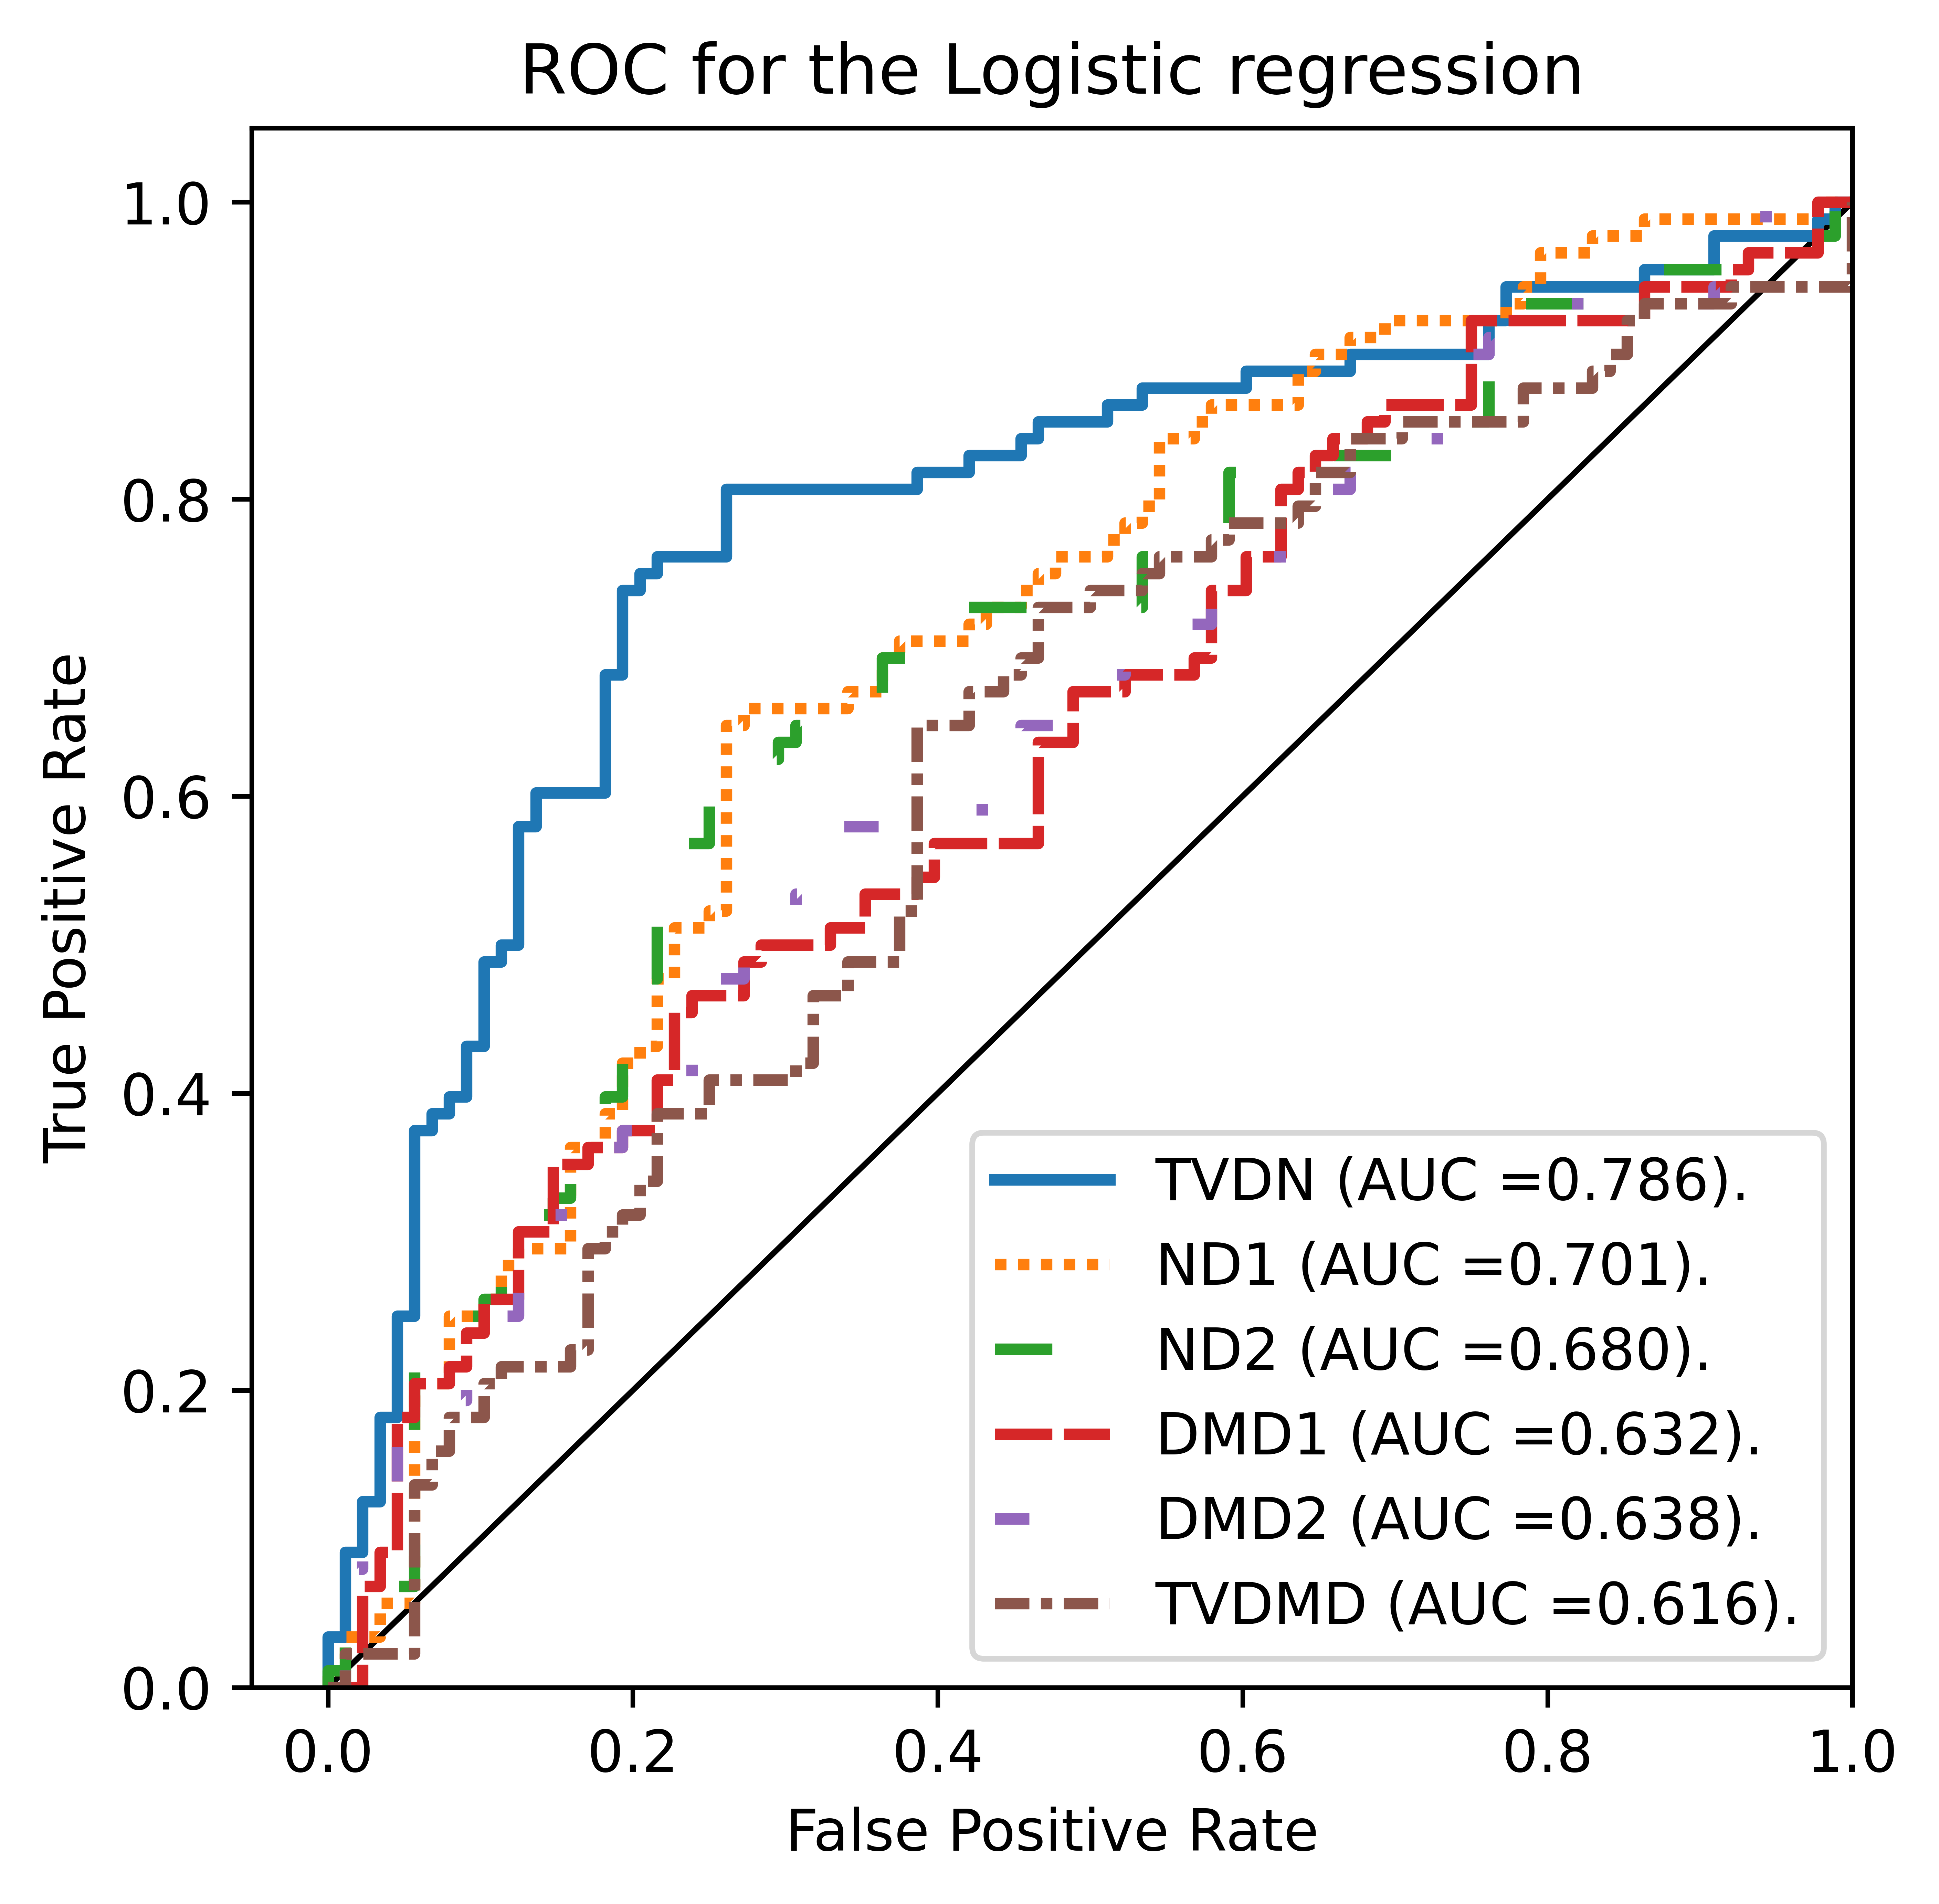

In [147]:
lss = [
     ("line", "-"),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
import seaborn as sns
cols = sns.color_palette(None, len(rocAll))
plt.figure(figsize=[5, 5], dpi=1200)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="-")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
flag = 0
for key, v in rocAll.items():
    plt.plot(v["fpr"], v["tpr"], label=f"{key} (AUC ={v['AUC']:.3f}).", lw=2, color=cols[flag], linestyle=lss[flag][-1])
    flag += 1
plt.legend(loc="lower right")
plt.savefig(f"./plots/{preFix}_rocAll.jpg", bbox_inches='tight')

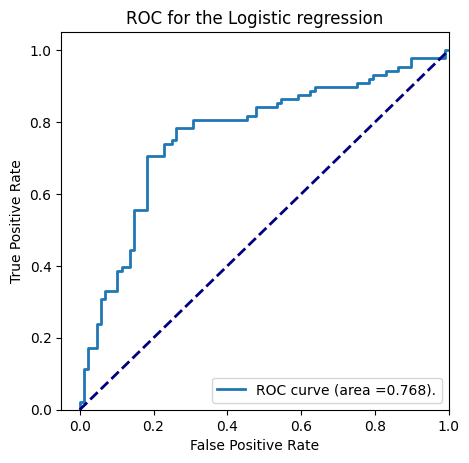

In [79]:
plt.figure(figsize=[5, 5], dpi=100)
plt.plot(gFpr, gTpr, label=f"ROC curve (area ={gAuc:.3f}).", lw=2, color=palette[0])
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")
#plt.savefig(f"./plots/{preFix}_roc.jpg", bbox_inches='tight')

#### Final fit

In [176]:
clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1)

##### Sel C by Hessian matrix of log reg (I do not think it is meaningful)

In [39]:
clfNoP = LogisticRegression(penalty=penalty, random_state=0, C=1e15)
clfNoP.fit(stdXs, Ys)
NoProbs = clfNoP.predict_proba(stdXs)[:, 1]
Dmat = np.diag(NoProbs*(1-NoProbs))
Hmat = np.matmul(np.matmul(stdXs.T, Dmat), stdXs)
_, Sigs, _ = np.linalg.svd(Hmat)

In [40]:
print(np.mean(Sigs), np.median(Sigs))

0.5301356344229998 0.014305366662637995


In [578]:
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(stdXs):
    clf = LogisticRegression(penalty=penalty, random_state=0, C=np.mean(Sigs))
    clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.7900974025974026


#### Select important features

##### LOO Confidence interval selection

Not good
(I do not use it)

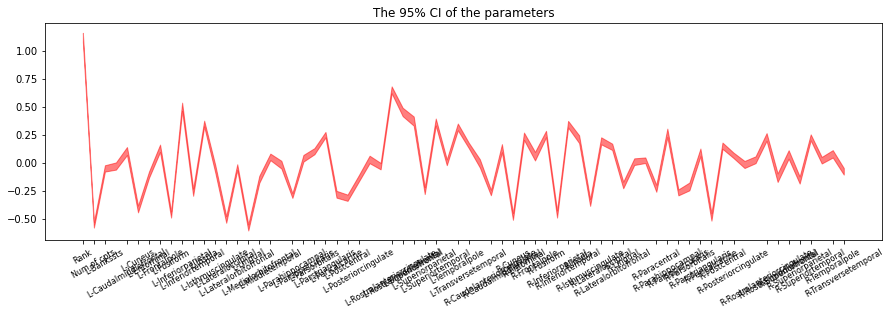

In [24]:
lows, ups = np.quantile(parass[:, :], [0.025, 0.975], axis=0)
#kpidxLOO = np.bitwise_and(lows !=0,  ups != 0)
kpidxLOO = np.bitwise_or(lows >0,  ups < 0)
kpidxLOOId = np.where(kpidxLOO)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxLOOId, xlabs[kpidxLOOId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySel.jpg", bbox_inches='tight')

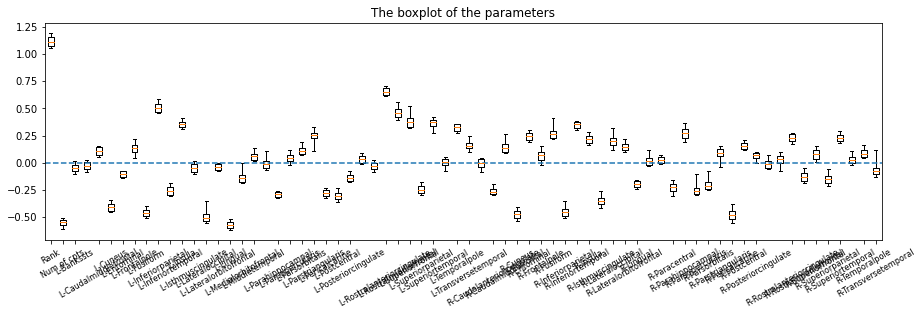

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parass[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parass[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parass[:, idx]), np.min(parass[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxLOOId, xlabs[kpidxLOOId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySel.jpg", bbox_inches='tight')

In [28]:
#md = sm.Logit(Ys, stdXs)
md = sm.Logit(Ys, sm.add_constant(stdXs[:, kpidxLOO])) # add intercept
mdres = md.fit()
print(mdres.summary())
print(xlabs[kpidxLOO][mdres.pvalues[1:]<0.05])
#print(xlabs[kpidx])

Optimization terminated successfully.
         Current function value: 0.218097
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  158
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           59
Date:                Sat, 26 Feb 2022   Pseudo R-squ.:                  0.6824
Time:                        09:43:30   Log-Likelihood:                -34.459
converged:                       True   LL-Null:                       -108.49
Covariance Type:            nonrobust   LLR p-value:                 1.316e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3484      2.107      2.064      0.039       0.219       8.478
x1             4.1258      1

##### Bootstrap Confidence interval selection

I use Bootstrap to select finally as it has better results

We can also calculate the pvalue based on bootstrap by assuming, under $H_0$, $\beta \sim N(0, \sigma^2)$. 

In [177]:
np.random.seed(0)
repTime = 10000
parassBoot = []
for i in tqdm(range(repTime)):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    parassBoot.append(parasBoot)

100%|██████████| 10000/10000 [00:13<00:00, 741.90it/s]


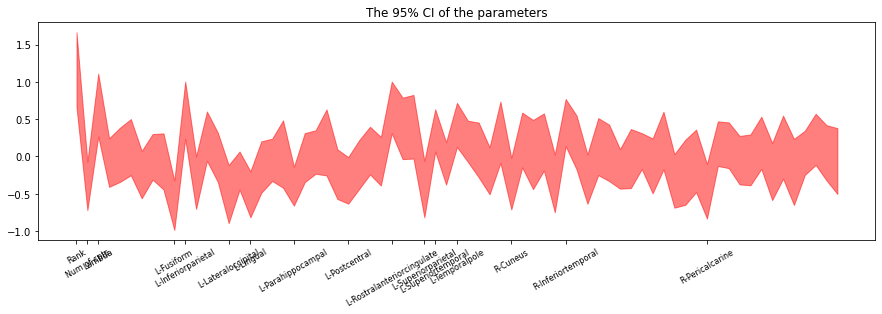

In [178]:
parassBoot = np.array(parassBoot)
#lows, ups = np.quantile(parassBoot[:, :], [0.025, 0.975], axis=0)
lows, ups = coefsFinal-parassBoot.std(axis=0)*1.96, coefsFinal+parassBoot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([["Rank", "Num of cpts", "Lambda"], regionNames])
#xlabs = np.array(regionNames)
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)

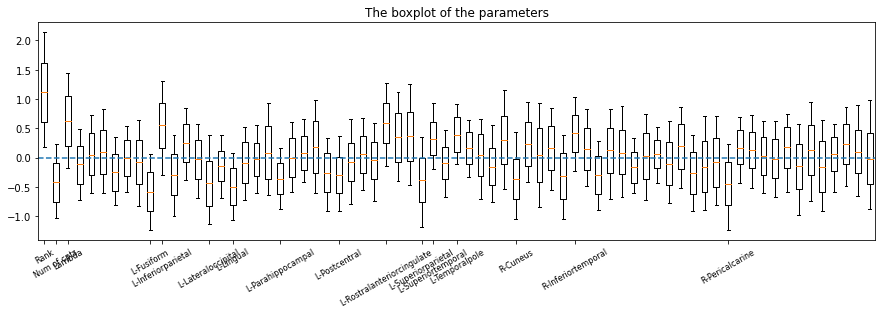

In [179]:
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parassBoot[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parassBoot[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parassBoot[:, idx]), np.min(parassBoot[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySelBoot.jpg", bbox_inches='tight')

In [180]:
# Pvalue
testStatsBoot = coefsFinal/parassBoot.std(axis=0)
#testStatsBoot = parassBoot.mean(axis=0)/parassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)))

In [181]:
# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(bootPvs <= 0.05, kpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": coefsFinal[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": bootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


##### Permutation test to obtain Pvs and sel parameter (We do not need it anymore)

In [241]:
np.random.seed(0)
repTime = 10000
parassPerm = []
for i in range(repTime):
    YsPerm = np.random.permutation(Ys)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(stdXs, YsPerm)
    parasPerm= clf.coef_.reshape(-1)
    parassPerm.append(parasPerm)
    
parassPerm = np.array(parassPerm)


#pvals = (np.abs(parassPerm) > np.abs(coefsFinal)).mean(axis=0)
pvals = np.array([(parassPerm > coefsFinal).mean(axis=0), (parassPerm < coefsFinal).mean(axis=0)]).min(axis=0)

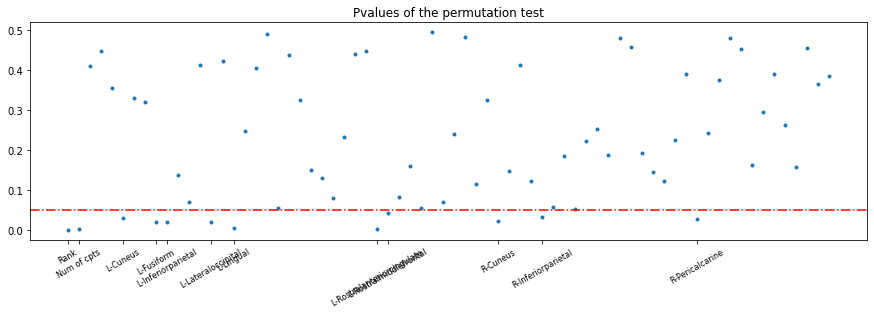

In [183]:
kpidxPerm = pvals < 0.05
kpidxIdPerm= np.where(kpidxPerm)[0]

plt.figure(figsize=[15, 4])
plt.plot(pvals, ".")
plt.axhline(y=0.05, color="red", ls="-.")
plt.title("Pvalues of the permutation test")
_ = plt.xticks(kpidxIdPerm, xlabs[kpidxIdPerm], rotation=30, fontsize=8)
plt.savefig(f"./plots/{preFix}_penaltySelPermPv.jpg", bbox_inches='tight')

##### The output table 

In [182]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefsFinal[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3f' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters  Lower  Upper  Pvalues
0                         Rank       1.164  0.662  1.666    0.000
1                  Num of cpts      -0.395 -0.720 -0.071    0.017
2                       Lambda       0.690  0.268  1.111    0.001
3                   L-Fusiform      -0.654 -0.985 -0.323    0.000
4           L-Inferiorparietal       0.621  0.237  1.005    0.002
5           L-Lateraloccipital      -0.505 -0.895 -0.115    0.011
6                    L-Lingual      -0.508 -0.817 -0.199    0.001
7            L-Parahippocampal      -0.399 -0.660 -0.137    0.003
8                L-Postcentral      -0.320 -0.633 -0.008    0.044
9   L-Rostralanteriorcingulate       0.657  0.311  1.004    0.000
10          L-Superiorparietal      -0.439 -0.816 -0.061    0.023
11          L-Superiortemporal       0.349  0.066  0.633    0.016
12              L-Temporalpole       0.423  0.127  0.720    0.005
13                    R-Cuneus      -0.366 -0.711 -0.020    0.038
14        

    #### Save data for brain under current model